In [5]:
from csv import reader

from numpy import array
from numpy import mean
from numpy import var
from numpy import corrcoef
from numpy import log
from numpy import sqrt
from numpy import arange
from numpy import zeros
from numpy import meshgrid

from matplotlib import rcParams

from matplotlib.pyplot import figure
from matplotlib.pyplot import axes
from matplotlib.pyplot import errorbar
from matplotlib.pyplot import plot
from matplotlib.pyplot import contourf
from matplotlib.pyplot import contour
from matplotlib.pyplot import colorbar
from matplotlib.pyplot import clabel
from matplotlib.pyplot import axis
from matplotlib.pyplot import xticks
from matplotlib.pyplot import yticks
from matplotlib.pyplot import tick_params
from matplotlib.pyplot import xlabel
from matplotlib.pyplot import ylabel
from matplotlib.pyplot import title
from matplotlib.pyplot import text
from matplotlib.pyplot import show

from scipy.optimize import fmin


In [6]:
#
# read data from a csv-file
#
readerout = reader(open("data/errorxydata.csv"),delimiter=',');
x = list(readerout);
data = array(x).astype('float')
xi = data[:,0]
yi = data[:,1]

# Error bars
sigmax = 0.5
sigmay = 0.8



In [7]:
#
# Statistics of the data
#

# number of data points
nn = len(data)
print('\nStatistics of the data:\nN = %1u data points'% (nn))

# mean of x-values
Meanx = mean(xi)
print('<x> = %1.2f'% (Meanx))

# mean of y-values
Meany = mean(yi)
print('<y> = %1.2f'% (Meany))

# Variance of x-values
Varx = var(xi)
print('Var(x) = %1.2f'% (Varx))

# Variance of y-values
Vary = var(yi)
print('Var(y) = %1.2f'% (Vary))

# Empirical correlation coefficient
rho = corrcoef(xi.T,yi.T)[0,1]
print('rho = %1.4f\n'% (rho))




Statistics of the data:
N = 20 data points
<x> = 10.68
<y> = 25.95
Var(x) = 30.57
Var(y) = 127.00
rho = 0.9957



Estimating scaled parameters:
Optimization terminated successfully.
         Current function value: -26.847778
         Iterations: 27
         Function evaluations: 51


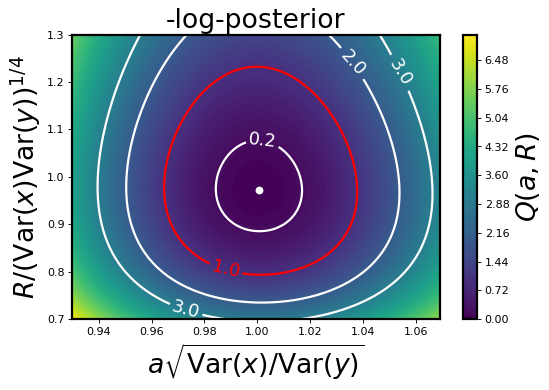

Scaled parameters:
a' = 1.000 +0.037/-0.036
R' = 0.97 +0.26/-0.18

Estimated parameters:
a = 2.039 +0.076/-0.073
b = 4.17 +/-0.83


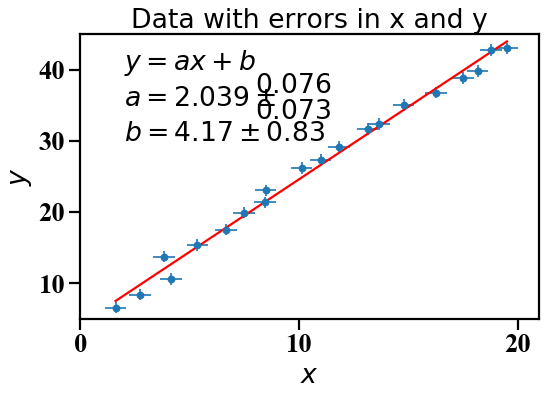

In [8]:
# Define the -log-posterior for a and R
def posteriorpdf(parms,sx,sy,rho,n):
    a = parms[0]
    R = parms[1]
    num = R*R*a*a - 2*R*R*rho*a + (sx*sx+sy*sy)*a + R*R
    denom = sx*sx*R*R*a*a + sx*sx*sy*sy*a + R*R*sy*sy
    p = num/denom
    q = sx*sx*R*R*a+sy*sy*R*R/a+sx*sx*sy*sy
    return log(R*a) + (n/2.)*log(q) + (n/2.)*p

# Minimization of the -log-posterior
print('Estimating scaled parameters:')
parms,Qmin,_,_,_ = fmin(posteriorpdf,[1.,1.],args=(sigmax/sqrt(Varx),sigmay/sqrt(Vary),rho,nn,),full_output=True)
aa = parms[0]
RR = parms[1]
 
# plot the -log-posterior
a = arange(0.93,1.07,0.001)
R = arange(0.7,1.3,0.01)
Q = zeros(shape=(len(R),len(a)))
X,Y = meshgrid(a,R)
for n in range(0,len(a)):
    for m in range(0,len(R)):
        Q[m,n] = posteriorpdf([a[n],R[m]],sigmax/sqrt(Varx),sigmay/sqrt(Vary),rho,nn)-Qmin


figure(
    num=2,
    figsize=(7,5.08),
    dpi=80,
    facecolor='white')
rcParams['axes.linewidth']=2
axes([0.15,0.18,0.82,0.70])
CS = contourf(X,Y,Q,100)
# We draw two contour lines into the plot, the smaller of which is suitable for reading the standard errors
CS2 = contour(CS,levels=[0.2,1,2,3],colors=('w','r','w','w'),linewidths=(2,))
clabel(CS2, inline=1, fmt='%1.1f', fontsize=16)
plot(aa,RR,'wo')
title('-log-posterior',fontsize=24)
xlabel(r'$a\sqrt{\mathrm{Var}(x)/\mathrm{Var}(y)}$',
    fontsize=24)
ylabel(r'$R/(\mathrm{Var}(x)\mathrm{Var}(y))^{1/4}$',
    fontsize=24)
cbar = colorbar(CS)
cbar.ax.set_ylabel(r'$Q(a,R)$',fontsize=24)
show()

# We determine the standard error of the parameters from the contour line
cc = CS2.collections[1].get_paths()[0]
CC = cc.vertices
sam = aa-min(CC[:,0])
sap = max(CC[:,0])-aa
sRm = RR-min(CC[:,1])
sRp = max(CC[:,1])-RR

print('Scaled parameters:')
print('a\' = %1.3f +%1.3f/-%1.3f'% (aa,sap,sam))
print('R\' = %1.2f +%1.2f/-%1.2f\n'% (RR,sRp,sRm))

# Calculating the slope and the intercept parameter and their errors
print('Estimated parameters:')
aest = aa*sqrt(Vary/Varx)
sam1 = sam*sqrt(Vary/Varx)
sap1 = sap*sqrt(Vary/Varx)
print('a = %1.3f +%1.3f/-%1.3f'% (aest,sap1,sam1))

best = Meany - Meanx*aest
bstd = sqrt( (sigmay*sigmay+sigmax*sigmax*aest)/nn + Meanx*Meanx*sam1*sap1)
print('b = %1.2f +/-%1.2f'% (best,bstd))

# 
# Plot data with error bars and fitted line
#
x = arange(min(xi),max(xi),0.1)
y = aest*x + best
figure(
    num=1,
    figsize=(7,5.08),
    dpi=80,
    facecolor='white')
rcParams['axes.linewidth']=2
axes([0.15,0.18,0.82,0.70])
errorbar(xi, yi, xerr=sigmax, yerr=sigmay, fmt='o')
plot(x,y,'r',linewidth=2)
axis([0,21,5,45])
xticks([0,10,20],
    fontsize=24,
    fontname='Times New Roman')
yticks([10,20,30,40],
    fontsize=24,
    fontname='Times New Roman')
tick_params(width=2,length=10)
xlabel(r'$x$',
    fontsize=24)
ylabel(r'$y$',
    fontsize=24)
title('Data with errors in x and y',fontsize=24)
text(2,40,r"$y = a x + b$",
    fontsize=24,
    fontname='Times New Roman')
text(2,35,r"$a = 2.039\pm$",
    fontsize=24,
    fontname='Times New Roman')
text(8,36.8,r"$0.076$",
    fontsize=24,
    fontname='Times New Roman')
text(8,33.2,r"$0.073$",
    fontsize=24,
    fontname='Times New Roman')
text(2,30,r"$b = 4.17\pm 0.83$",
    fontsize=24,
    fontname='Times New Roman')

show()
